In [0]:
#                                                                                  Convolutional Neural network with 4 layers
#                                                                                   Learning rate decay from 0.003 to 0.0001
#                                                                                 max-pooling of size [1, 2, 2, 1], stride = 2
#                                                                                         dropout(keep_prob --> 0.75)
#
# · · · · · · · · · ·      (input data, 1 --> no. of channels)                          X [minibatch_size, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @      -- (conv. + max_pool) layer 5x5x1=>16 stride 1               W1 [5, 5, 1, 16]        b1 [16]          (5x5 -- size of filter, 1 -- input channel, 16 -- output channels)
#     ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                                       Z1 [minibatch_size, 28, 28, 16]           
#    input 28x28x16    --->   max_pool --> 2 x 2, stride 2 -- output  ----------->      P1 --> 14x14x16
#
#   @ @ @ @ @ @ @ @        -- (conv. + max_pool) layer 5x5x16=>32 stride 1              W2 [5, 5, 16, 32]        b2 [32]          (5x5 -- size of filter, 16 -- input channels, 32 -- output channels)
#       ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                                        Z2 [minibatch_size, 14, 14, 32]
#    input 14x14x32    --->   max_pool --> 2 x 2, stride 2 -- output  ----------->      P2 --> 7x7x32
#
#        ∶∶∶∶∶∶∶∶∶∶∶                                                       -----------> reshaped to p --> [minibatch_size, 7*7*32]
#      \x/x\x\x/           -- fully connected layer (relu + dropout)                   W3 [7*7*32, 200]       b3 [200]        (200 --> no. of neurons in fully connected layer)
#       · · · ·                                                                        Z3 [minibatch_size, 200]
#       \x/x\x/            -- fully connected layer (softmax)                          W4 [200, 10]           b4 [10]         (10 --> output classes (0 to 9))
#        · · ·                                                                         Z4 [minibatch_size, 10]

In [0]:
# Import libraries
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

In [3]:
# Load mnist dataset
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("data", one_hot = True, reshape = False)

print("\nNo. of training examples: ", mnist.train.images.shape[0])
print("No. of test examples: ", mnist.test.images.shape[0])

print("\nShape of mnist.train.images: ", mnist.train.images.shape)
print("Shape of mnist.train.labels: ", mnist.train.labels.shape)
print("Shape of mnist.test.images: ", mnist.test.images.shape)
print("Shape of mnist.test.labels: ", mnist.test.labels.shape)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz

No. of training examples:  55000
No. of test examples:  10000

Shape of mnist.train.images:  (55000, 28, 28, 1)
Shape of mnist.train.labels:  (55000, 10)
Shape of mnist.test.images:  (10000, 28, 28, 1)
Shape of mnist.test.labels:  (10000, 10)


In [0]:
# Number of channels
channels = [1, 16, 32]

# channels[0] = 1 -->  (input image channel)
# channels[1] = 16 -->  (first convolutional + max_pool layer output depth)
# channels[2] = 32 -->  (second convolutional + max_pool layer output depth)

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0]
    Y -- placeholder for the input labels, of shape [None, n_y]
    """

    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    keep_prob = tf.placeholder(tf.float32)
    
    return X, Y, keep_prob

In [0]:
def initialize_parameters():
    """
    Initializes parameters to build a convolutional neural network with tensorflow.
    The shapes are:
                        W1 : [5, 5, 1, 16]
                        b1 : [16]
                        W2 : [5, 5, 16, 32]
                        b2 : [32]
                        W3 : [7*7*32, 200]
                        b3 : [200]
                        W4 : [200, 10]
                        b4 : [10]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3, W4, b4
    """
    # Random initialization of weights : to break symmetry
    # (if all weights are same, all units in hidden layer will be same too)
    W1 = tf.Variable(tf.truncated_normal([5, 5, channels[0], channels[1]], stddev = 0.1))              # 5x5 filter size, channels[0] = 1 --> input channel, channels[1] = 16 -->output channels
    b1 = tf.Variable(tf.ones([channels[1]]) / 10)
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, channels[1], channels[2]], stddev = 0.1))
    b2 = tf.Variable(tf.ones([channels[2]]) / 10)

    W3 = tf.Variable(tf.truncated_normal([7 * 7 * channels[2], 200], stddev = 0.1))
    b3 = tf.Variable(tf.ones([200]) / 10)
    
    W4 = tf.Variable(tf.truncated_normal([200, 10], stddev = 0.1))
    b4 = tf.Variable(tf.ones([10]) / 10)
    
    
    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3,
                  "W4": W4, "b4": b4}
    
    return parameters

In [0]:
def forward_propagation_with_dropout(X, parameters, keep_prob):
    """
    Implements forward propagation
    
    Arguments:
    X -- input dataset placeholder, of shape (number of examples, height, width, channels)
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"

    Returns:
    Z4 -- the output of softmax layer
    YLogits -- weighted sum + bias of last layer
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    W4 = parameters["W4"]
    b4 = parameters["b4"]
    
    conv_stride = 1
    pool_stride = 2
    
    # output is 14x14(due to max_pool)
    Z1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides = [1, conv_stride, conv_stride, 1], padding = 'SAME') + b1)
    P1 = tf.nn.max_pool(Z1, ksize = [1, 2, 2, 1], strides = [1, pool_stride, pool_stride, 1], padding = 'SAME')
    
    # output is 7x7(due to max_pool)
    Z2 = tf.nn.relu(tf.nn.conv2d(P1, W2, strides = [1, conv_stride, conv_stride, 1], padding = 'SAME') + b2)
    P2 = tf.nn.max_pool(Z2, ksize = [1, 2, 2, 1], strides = [1, pool_stride, pool_stride, 1], padding = 'SAME')

    # reshape the output from the second layer for the fully connected layer
    p = tf.reshape(P2, shape = [-1, 7 * 7 * channels[2]])

    Z3 = tf.nn.relu(tf.matmul(p, W3) + b3)
    
    d3 = tf.nn.dropout(Z3, keep_prob)
    
    YLogits = tf.matmul(d3, W4) + b4
    
    Z4 = tf.nn.softmax(YLogits)
     
    return Z4, YLogits

In [0]:
def compute_cost(YLogits, Y):
    """
    Computes the cost
    
    Arguments:
    YLogits -- weighted sum + bias of last layer
    Y -- "true" labels vector placeholder, same shape as YLogits(Z4)
    
    Returns:
    cross_entropy - Tensor of the cost function
    """
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = YLogits, labels = Y)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    return cross_entropy

In [0]:
def model(lr_min, lr_max, decay_speed, num_epochs, minibatch_size, print_epoch_results = True):
    """
    Implements a tensorflow model of Convolutional neural network
    
    Arguments:
    lr_min -- minimum value of learning rate(final value)
    lr_max -- maximum value of learning rate(initial value)
    decay_speed -- speed at which learning rate to be decreased
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_epoch_results -- True to print the cost and accuracies every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                                      # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = mnist.train.images.shape               # (m : number of examples in the train set, n_H0 : height of image, n_W0 : width of image, n_C0 : channels image)
    n_y = mnist.train.labels.shape[1]                              # n_y : output size
    costs = []                                                     # To keep track of the cost
    train_acc = []                                                 # To keep track of the training set accuracy
    test_acc = []                                                  # To keep track of the test set accuracy
    num_minibatches = int(m / minibatch_size) + 1                  # number of minibatches of size minibatch_size in the train set

    # Create Placeholders of shape (n_x, n_y)
    X, Y, keep_prob = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4, YLogits = forward_propagation_with_dropout(X, parameters, keep_prob)
    
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z4, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(YLogits, Y)
    
    # Placeholder for learning rate
    lr = tf.placeholder(tf.float32)
    
    # Backpropagation: AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            learning_rate = lr_min + (lr_max - lr_min) * math.exp(-epoch / decay_speed)

            epoch_cost = 0.                                                  # Defines a cost related to an epoch

            for i in range(num_minibatches):

                # Get minibatch
                minibatch_X, minibatch_Y = mnist.train.next_batch(minibatch_size)
                train_data = {X: minibatch_X, Y: minibatch_Y}                
                
                # Run the session to execute the "optimizer" and the "cost".
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y, lr : learning_rate, keep_prob : 0.75})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Get train and test set accuracy for every epoch
            epoch_train_acc = accuracy.eval(session = sess, feed_dict = {X: mnist.train.images, Y: mnist.train.labels, keep_prob : 1.0})
            epoch_test_acc = accuracy.eval(session = sess, feed_dict = {X: mnist.test.images, Y: mnist.test.labels, keep_prob : 1.0})
            
            costs.append(epoch_cost)
            train_acc.append(epoch_train_acc)
            test_acc.append(epoch_test_acc)
            
            # Print the cost
            if print_epoch_results == True and epoch % 10 == 0:
                print ("epoch %i: cost = %f, training accuracy = %f, test accuracy = %f" % (epoch, epoch_cost, epoch_train_acc, epoch_test_acc))
                
        print("")
        # Plot cost
        plt.subplot(1, 3, 1)
        plt.plot(costs)
        plt.ylabel("cost")
        plt.xlabel("epochs")
        plt.title("Convolutional Neural Network")
        
        # Plot train accuracy
        plt.subplot(1, 3, 2)
        plt.plot(np.squeeze(train_acc))
        plt.ylabel("Training set accuracy")
        plt.xlabel("epochs")
        plt.title("Convolutional Neural Network")

        # Plot test accuracy
        plt.subplot(1, 3, 3)
        plt.plot(np.squeeze(test_acc))
        plt.ylabel("Test set accuracy")
        plt.xlabel("epochs")
        plt.title("Convolutional Neural Network")
        
        plt.subplots_adjust(top = 0.92, bottom = 0.08, left = 0.8, right = 3, hspace = 0.25, wspace = 0.8)
        plt.show()
        
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        print("\nFinal Accuracy:\n")
        
        # Calculate accuracy on the train set
        print("Train Accuracy:", accuracy.eval(session = sess, feed_dict = {X: mnist.train.images, Y: mnist.train.labels, keep_prob : 1.0}))
        
        # Calculate accuracy on the test set
        print("Test Accuracy:", accuracy.eval(session = sess, feed_dict = {X: mnist.test.images, Y: mnist.test.labels, keep_prob : 1.0}))
        
        return parameters

epoch 0: cost = 16.951028, training accuracy = 0.986182, test accuracy = 0.986200
epoch 10: cost = 0.404716, training accuracy = 0.999182, test accuracy = 0.992600
epoch 20: cost = 0.060701, training accuracy = 0.999982, test accuracy = 0.993900
epoch 30: cost = 0.021757, training accuracy = 1.000000, test accuracy = 0.994400
epoch 40: cost = 0.015564, training accuracy = 1.000000, test accuracy = 0.994600



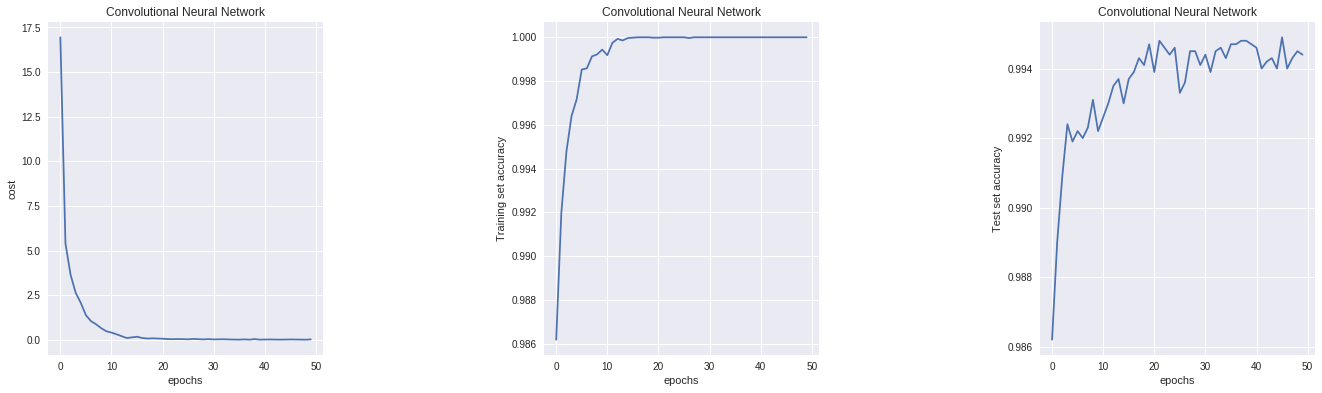

Parameters have been trained!

Final Accuracy:

Train Accuracy: 1.0
Test Accuracy: 0.9944


In [10]:
parameters = model(lr_min = 0.0001, lr_max = 0.003, decay_speed = 7,  num_epochs = 50, minibatch_size = 64)